In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

%matplotlib inline

# Урок 3. Кейс 1. Работа с признаками и селекция.

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.**

In [2]:
data = pd.read_csv('./datasets/my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_m = data.resample('M').mean()

data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


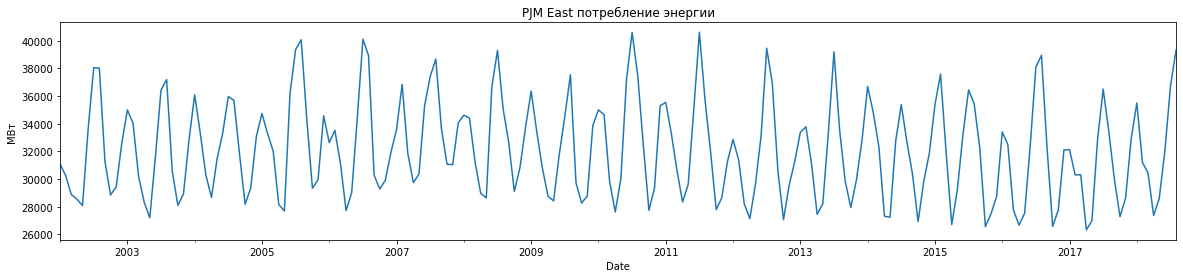

In [7]:
data_m['PJME_MW'].plot(style='-', figsize=(20,4))
plt.title('PJM East потребление энергии')
plt.ylabel('МВт')
plt.show()

**2. Подберите параметры модели SARIMAX для этого ряда.**

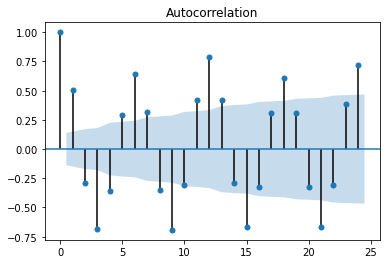

In [9]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'], lags=12*2)
plt.show()

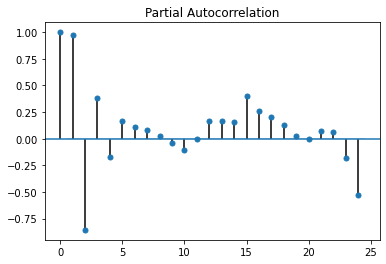

In [10]:
sm.graphics.tsa.plot_pacf(data['PJME_MW'], lags=12*2)
plt.show()

In [17]:
# Определим p, d и q 
q = 0
p = 1
d = 2
pdq = [p, d, q]

# определим комбинации сезонных параметров p, q и q, 
qs = 0
ps = 1
ds = 2
seasonal_pdq = [ps, ds, qs , 12] 

In [18]:
model = sm.tsa.statespace.SARIMAX(
    data_m['PJME_MW'].values[:-20],
    order=pdq,
    seasonal_order=seasonal_pdq,
    enforce_stationarity= False,
    enforce_invertibility=False
)

results = model.fit()
print(f'SARIMAX{pdq}x{seasonal_pdq} - AIC:{results.aic}')

SARIMAX[1, 2, 0]x[1, 2, 0, 12] - AIC:2754.1041044026347


In [19]:
print(results.summary().tables[0],results.summary().tables[1])

SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 2, 0)x(1, 2, 0, 12)   Log Likelihood               -1374.052
Date:                            Sat, 08 Aug 2020   AIC                           2754.104
Time:                                    15:09:55   BIC                           2762.950
Sample:                                         0   HQIC                          2757.699
                                            - 180                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

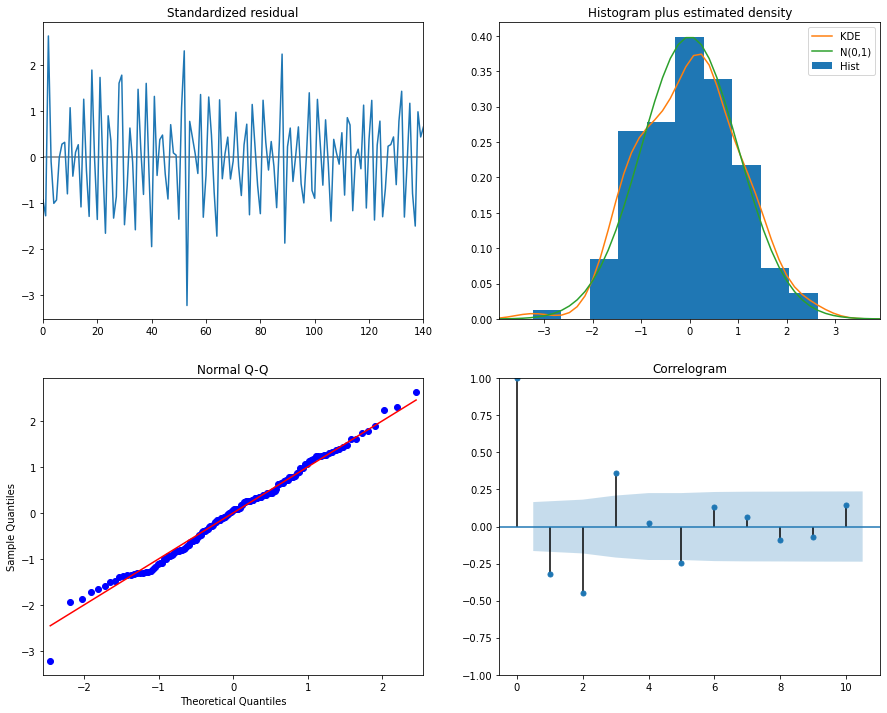

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.**

**4. Возмите вариант 1 или 2**

    Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

**5. Оцените результат моделирования.**

**6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.**